# <font size="10">Desafío Spike</font>
## Francisca Palacios Coddou

# 1. Costos marginales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sagemaker
import seaborn as sn

### Importamos los archivos:

In [2]:
costo_marginal_real = 'Data/costo_marginal_real.csv'
costo_marginal_real_df = pd.read_csv(costo_marginal_real)

costo_marginal_real_df.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [3]:
costo_marginal_programado = 'Data/costo_marginal_programado.csv'
costo_marginal_programado_df = pd.read_csv(costo_marginal_programado)

costo_marginal_programado_df.head()

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5,49.796216


### Merge de los archivos a nivel de barra:

In [4]:
# Cambiamos primero el nombre de la columna de join para que sea igual en ambos archivos.
costo_marginal_programado_df.rename(columns={'mnemotecnico_barra': 'barra_mnemotecnico'}, inplace=True)

In [5]:
costo_marginal = pd.merge(costo_marginal_real_df, costo_marginal_programado_df, 
                          how='inner',  
                          left_on=['barra_mnemotecnico','fecha','hora'], 
                          right_on = ['barra_mnemotecnico','fecha','hora'])

### Ahora hacemos un análisis exploratorio de la base resultante:

In [6]:
# Intersección
costo_marginal['barra_mnemotecnico'].value_counts()

BA02T003SE004T003    8690
BA01T002SE036T002    8690
BA83L131SE134L131    7538
BA03G010SE001G010    4345
BA01T002SE100T002    4345
                     ... 
BA01T038SE001G130    2160
BA74T005SE278T005    2160
BA88T005SE275T005    2160
BA68T005SE277T005    2160
BA01T005SE284T005    2160
Name: barra_mnemotecnico, Length: 220, dtype: int64

In [7]:
# Unión
pd.merge(costo_marginal_real_df, costo_marginal_programado_df, 
         how='outer', 
         left_on=['barra_mnemotecnico','fecha','hora'], 
         right_on = ['barra_mnemotecnico','fecha','hora'])['barra_mnemotecnico'].value_counts()

-                    180115
BA02T003SE004T003      8690
BA01T002SE036T002      8690
BA83L131SE134L131      8114
BA01R002SE001R002      4345
                      ...  
BA42G216SE187G216      1464
BA65T005SE277T005       744
BA87T005SE275T005       744
BA56T005SE276T005       744
BA01G460SE002G460       720
Name: barra_mnemotecnico, Length: 1039, dtype: int64

### Con esto vemos que el costo se programa para 220 barras (intersección), del total de 1038 barras si descontamos las etiquetadas como '-' (unión). Es decir, el costo se programa usando un 21.2% de los valores únicos de barra.

In [8]:
costo_marginal.dtypes

barra_mnemotecnico                object
barra_referencia_mnemotecnico     object
fecha                             object
hora                               int64
costo_en_dolares                 float64
costo_en_pesos                   float64
nombre                            object
nombre_barra                      object
costo                            float64
dtype: object

In [9]:
costo_marginal.describe()

,hora,costo_en_dolares,costo_en_pesos,costo
count,913388.000000,913388.000000,913388.000000,913388.000000
mean,12.502901,58.566654,39.512227,61.888004
std,6.924006,23.276453,15.555780,23.806896
min,1.000000,0.000000,0.000000,-12.113677
25%,7.000000,48.440000,32.559880,49.981588
50%,13.000000,53.330000,35.965290,55.057527
75%,19.000000,60.890000,41.258260,64.181228
max,25.000000,791.140000,523.418220,610.600000


### Es importante notar que los datos de fecha no están en el formato adecuado y debemos convertirlas al tipo datetime. En promedio, el costo programado (en dólares) representa un 105.7% del costo real. Ambos costos están distribuidos similarmente, con desviaciones estándar bastante cercanas. El costo programado muestra valores negativos, por lo que se podría indagar más en eso y estudiar cómo esto afecta nuestro modelo.

In [10]:
costo_marginal.fecha = pd.to_datetime(costo_marginal.fecha, format='%Y-%m-%d')

In [11]:
costo_marginal[costo_marginal.duplicated(['barra_mnemotecnico', 'fecha', 'hora'])]['barra_mnemotecnico'].value_counts()

BA02T003SE004T003    4345
BA01T002SE036T002    4345
BA83L131SE134L131    3769
Name: barra_mnemotecnico, dtype: int64

### Encontramos que existen tres barras duplicadas a nivel de 'barra_mnemotecnico', 'fecha' y 'hora'.

# 2. Construcción de variables

In [12]:
costo_marginal['desviación'] = costo_marginal['costo_en_dolares'] - costo_marginal['costo']

In [13]:
costo_marginal['desviación_pct'] = (costo_marginal['costo_en_dolares'] - costo_marginal['costo'])*100/costo_marginal['costo_en_dolares']

In [14]:
costo_marginal['desviacion_cat'] = 0
costo_marginal.loc[(abs(costo_marginal['desviación_pct']) > 15), 'desviacion_cat'] = 1

In [15]:
costo_marginal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre,nombre_barra,costo,desviación,desviación_pct,desviacion_cat
0,BA01G021SE018G021,BA02T002SE032T002,2019-04-06,25,58.02,38.65989,BA S/E CENTRAL QUINTERO 220KV,BA S/E CENTRAL QUINTERO 220KV,54.292145,3.727855,6.425121,0
1,BA01T018SE001T018,BA02T002SE032T002,2019-04-06,25,63.60,42.37795,BA S/E NUEVA PICHIRROPULLI 220KV B1,BA S/E NUEVA PICHIRROPULLI 220KV B1,60.620648,2.979352,4.684516,0
2,BA02T005SE055T005,BA02T002SE032T002,2019-04-06,25,62.78,41.83157,BA S/E SAN FRANCISCO DE MOSTAZAL 66KV T1,BA S/E SAN FRANCISCO DE MOSTAZAL 66KV T1,59.177969,3.602031,5.737545,0
3,BA01T002SE029T002,BA02T002SE032T002,2019-04-06,25,58.55,39.01304,BA S/E CENTRAL PEHUENCHE 220KV B1,BA S/E CENTRAL PEHUENCHE 220KV B1,54.566605,3.983395,6.803407,0
4,BA01R002SE041R002,BA02T002SE032T002,2019-04-06,25,60.39,40.23906,BA S/E SAN CRISTOBAL 110KV B1,BA S/E SAN CRISTOBAL 110KV B1,56.086260,4.303740,7.126576,0


### Analizamos la variable desviacion_cat:

In [16]:
one_df=costo_marginal[costo_marginal['desviacion_cat']==1]
cero_df=costo_marginal[costo_marginal['desviacion_cat']==0]

In [18]:
x = one_df['desviacion_cat'].groupby([one_df['fecha'].dt.year, one_df['fecha'].dt.month]).count()
y = cero_df['desviacion_cat'].groupby([cero_df['fecha'].dt.year, cero_df['fecha'].dt.month]).count()
print(x,y)

fecha  fecha
2019   1        48230
       2        51007
       3        45956
       4        50625
       5        40257
       6        12100
Name: desviacion_cat, dtype: int64 fecha  fecha
2019   1        116938
       2         98177
       3        119956
       4        102227
       5        117471
       6        110444
Name: desviacion_cat, dtype: int64


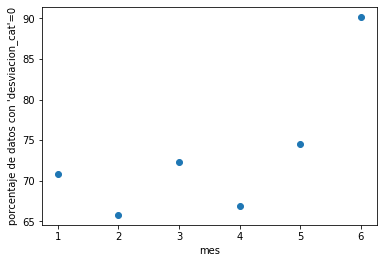

In [19]:
porcentaje = np.zeros(6)
for i in range(len(x)):
    x = np.array(x)
    y = np.array(y)
    porcentaje[i] = y[i]*100/(y[i]+x[i])

plt.xlabel('mes')
plt.ylabel("porcentaje de datos con 'desviacion_cat'=0")
plt.scatter([1,2,3,4,5,6], porcentaje)
plt.show()

### Con esto podemos observar que junio tuvo un notorio aumento del porcentaje de barras que tuvieron una desviación_pct absoluta menor a 15%; es decir, de desviacion_cat igual a 0. Eso quiere decir que en junio el costo marginal programado se ajustó mejor que otros meses al costo marginal real. 

# 3. Visualización de datos

In [20]:
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
    
    df = costo_marginal.loc[costo_marginal['barra_mnemotecnico'] == codigo_barra]
    ax = plt.gca()
    df.plot.line(x='fecha',y ='costo', ax=ax, label='cmg_prog')
    df.plot.line(x='fecha',y ='costo_en_dolares', ax=ax, label='cmg_real')
    ax.set_xlim([fecha_inicial, fecha_final])
    
    plt.xlabel('fecha')
    plt.ylabel('costo en dólares')
    
    return plt.show()

### Enero-Marzo barra BA01T002SE002T002:

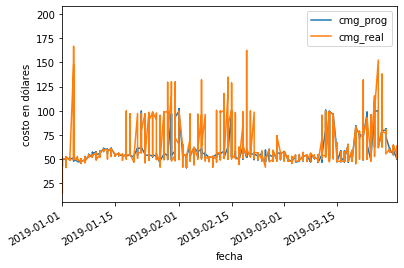

In [21]:
time_plot_costo_barra('BA01T002SE002T002', '2019-01-01', '2019-03-31')

### Abril-Junio barra BA01T002SE002T002:

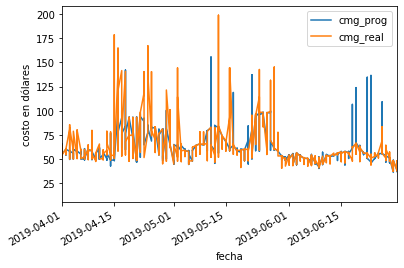

In [22]:
time_plot_costo_barra('BA01T002SE002T002', '2019-04-01', '2019-06-30')

### Enero-Marzo barra BA01T005SE057T005:

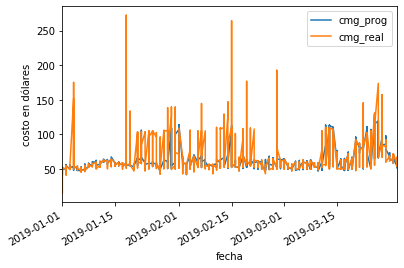

In [23]:
time_plot_costo_barra('BA01T005SE057T005', '2019-01-01', '2019-03-31')

### Abril-Junio barra BA01T005SE057T005:

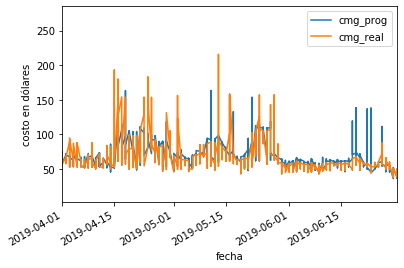

In [24]:
time_plot_costo_barra('BA01T005SE057T005', '2019-04-01', '2019-06-30')

### Enero-Marzo barra BA01T005SE046T005:

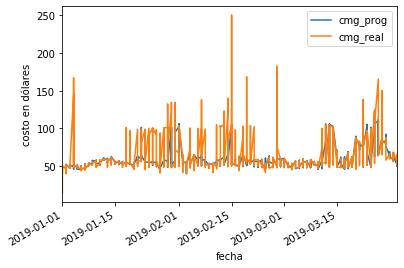

In [25]:
time_plot_costo_barra('BA01T005SE046T005', '2019-01-01', '2019-03-31')

### Abril-Junio barra BA01T005SE046T005:

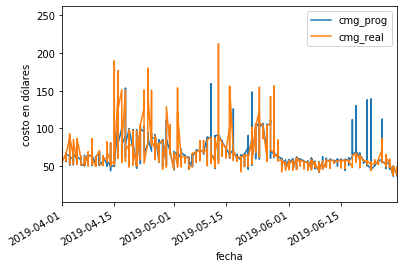

In [26]:
time_plot_costo_barra('BA01T005SE046T005', '2019-04-01', '2019-06-30')

### Al dividir los gráficos de las barras para Enero-Marzo y Abril-Junio, podemos notar que los costos marginales tienden a ser más altos en los meses de otoño-invierno que verano-otoño. Esto tiene sentido, ya que en estos meses existe un mayor consumo de energía eléctrica para, por ejemplo, calefacción e iluminación. Podemos observar también que el costo marginal programado puede presentar problemas para ajustarse a los peaks del costo marginal real. 

### Buscamos la barra que tiene cmg_real=0 durante todos los días y la eliminamos del dataset:

In [27]:
for i in costo_marginal.barra_mnemotecnico.unique():
    arr = np.array(costo_marginal.loc[(costo_marginal['barra_mnemotecnico'] == i)]['costo_en_dolares'])
    all_zeros = not np.any(arr)
    if all_zeros == True:
        costo_marginal = costo_marginal[costo_marginal.barra_mnemotecnico != i]

# 4. Base para los modelos

### Importamos los archivos:

In [28]:
base_para_prediccion = 'Data/base_para_prediccion.csv'
base_para_prediccion_df = pd.read_csv(base_para_prediccion)

base_para_prediccion_df.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


### Analizamos de qué tipo son los datos: 

In [29]:
base_para_prediccion_df.dtypes

nemotecnico_se               object
fecha                        object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
dtype: object

In [30]:
base_para_prediccion_df.shape

(112779, 15)

### Vemos que la base de datos contiene 15 variables y 112779 ejemplos. En esta base las fechas también deben ser convertidas al formato datetime.

In [31]:
base_para_prediccion_df.describe(include='all')

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779,112779,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
unique,29,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,SE004T002,2019-04-06 00:00:00 UTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4345,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,NaN,NaN,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,NaN,NaN,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,NaN,NaN,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,NaN,NaN,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,NaN,NaN,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500


In [32]:
base_para_prediccion_df['fecha'] = base_para_prediccion_df['fecha'].astype('datetime64[ns]')
base_para_prediccion_df.fecha.dt.month.value_counts()

5    20088
4    19467
3    19344
1    18792
6    17712
2    17376
Name: fecha, dtype: int64

In [33]:
base_para_prediccion_df['n_barras'].value_counts()

1    36945
2    30535
3    29263
4     7346
6     4345
5     4345
Name: n_barras, dtype: int64

### Podemos observar que las series de generación tienen valores incompletos, que podríamos después convertir a ceros para entrenar el modelo. La base de datos contiene los meses desde enero hasta junio y podemos notar que en estos meses existe una fluctuación importante de la demanda energética (posiblemente por la transición verano-invierno). También vemos que la mayoría de las subestaciones tiene entre 1 y 3 barras conectadas.

In [34]:
base_para_prediccion_df[base_para_prediccion_df.duplicated(['nemotecnico_se', 'fecha', 'hora'])]['nemotecnico_se'].value_counts()


Series([], Name: nemotecnico_se, dtype: int64)

### Vemos que no hay duplicados para valores de 'nemotecnico_se', 'fecha' y 'hora'.

### Creamos nuevas variables a partir de la variable fecha:

In [35]:
base_para_prediccion_df['año'] = base_para_prediccion_df.fecha.dt.year
base_para_prediccion_df['mes'] = base_para_prediccion_df.fecha.dt.month
base_para_prediccion_df['día'] = base_para_prediccion_df.fecha.dt.day
base_para_prediccion_df['día_semana'] = base_para_prediccion_df.fecha.dt.day_name()

### La variable weekday_weekend tendrá un valor de 0 para días de la semana y 1 para días del fin de semana

In [36]:
base_para_prediccion_df['weekday_weekend'] = 0
base_para_prediccion_df.loc[(base_para_prediccion_df['día_semana'] == 'Sunday'), 'weekday_weekend'] = 1
base_para_prediccion_df.loc[(base_para_prediccion_df['día_semana'] == 'Saturday'), 'weekday_weekend'] = 1
base_para_prediccion_df.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,día,día_semana,weekday_weekend
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785,2019,1,4,Friday,0
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785,2019,1,4,Friday,0
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,2019,1,4,Friday,0
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,2019,1,4,Friday,0
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,2019,1,4,Friday,0


### Creamos una función que para una subestación y una variable, grafique múltiples series de tiempo diarias:

In [37]:
def graf_mult_series(codigo, variable, lista_fechas):
    
    for i in range(len(lista_fechas)):
        df = base_para_prediccion_df.loc[(base_para_prediccion_df['nemotecnico_se'] == codigo) & (base_para_prediccion_df['fecha'] == lista_fechas[i])]
        ax = plt.gca()
        df.plot.scatter(x='hora',y =variable, ax=ax, label=lista_fechas[i], color=np.random.rand(3,).reshape(1,-1))
    
    return plt.show()

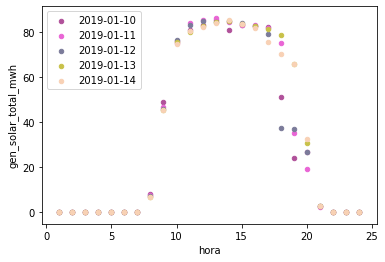

In [38]:
lista_fechas = ['2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14']
graf_mult_series('SE005T002', 'gen_solar_total_mwh', lista_fechas)

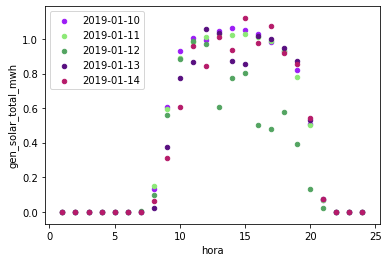

In [39]:
lista_fechas = ['2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14']
graf_mult_series('SE127T005', 'gen_solar_total_mwh', lista_fechas)

### Podemos observar que en ambos gráficos existe una mayor generacón de energía solar durante el día, lo que hace sentido dada la fuente de donde se obtiene. Existe una notoria diferencia de los valores de generación de energía a lo largo de día entre las subestaciones. Es posible que la primera subestación se encuentre en un lugar con un clima más cálido (podría estar más al norte de Chile) que la segunda subestación o también podría deberse a que tiene una mayor capacidad. 

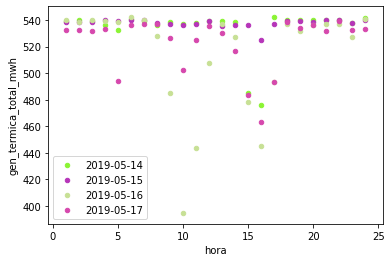

In [40]:
lista_fechas = ['2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17']
graf_mult_series('SE020G213', 'gen_termica_total_mwh', lista_fechas)

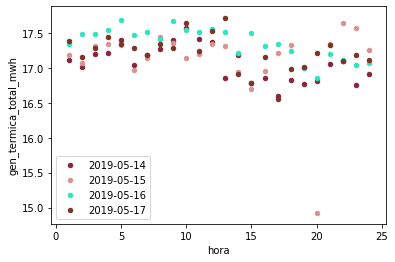

In [41]:
lista_fechas = ['2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17']
graf_mult_series('SE106G216', 'gen_termica_total_mwh', lista_fechas)

### Vemos que la generación de energía térmica se distribuye más homogenamente a lo largo del día que la solar, ya que puede generarse continuamente. La primera subestación térmica generó notoriamente más energía que la segunda, pudiendo deberse a que posee una mayor capacidad.

# 5. Predicción de desviaciones del costo marginal: modelo 1

### Cambiamos los valores NaN por ceros para luego poder entrenar el modelo:

In [42]:
base_para_prediccion_df = base_para_prediccion_df.fillna(0)

### Creamos la variable target (que después modificaremos):

In [43]:
base_para_prediccion_df['pre_target'] = 0
base_para_prediccion_df.loc[(abs(base_para_prediccion_df['cmg_desv_pct']) > 15), 'pre_target'] = 1

### Ordenamos la base de datos por subestación-fecha-hora:

In [44]:
base_para_prediccion_df = base_para_prediccion_df.sort_values(['nemotecnico_se', 'fecha', 'hora'])
base_para_prediccion_df = base_para_prediccion_df.reset_index(drop=True)
base_para_prediccion_df.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,día,día_semana,weekday_weekend,pre_target
0,SE001T002,2019-01-01,1,0.0,0.0,0.0,0.0,0.0,54.03,124.604410,...,-56.64,2,61148556,14.2881,2019,1,1,Tuesday,0,1
1,SE001T002,2019-01-01,2,0.0,0.0,0.0,0.0,0.0,54.03,125.415516,...,-56.92,2,136880002,14.2881,2019,1,1,Tuesday,0,1
2,SE001T002,2019-01-01,3,0.0,0.0,0.0,0.0,0.0,54.03,52.383209,...,3.15,2,127833826,14.2881,2019,1,1,Tuesday,0,0
3,SE001T002,2019-01-01,4,0.0,0.0,0.0,0.0,0.0,54.03,53.482023,...,1.03,2,133924965,14.2881,2019,1,1,Tuesday,0,0
4,SE001T002,2019-01-01,5,0.0,0.0,0.0,0.0,0.0,54.03,52.260469,...,3.39,2,138980453,14.2881,2019,1,1,Tuesday,0,0


### Creamos nuevas variables:

In [45]:
base_para_prediccion_df['en_total_mwh'] = base_para_prediccion_df['gen_eolica_total_mwh'] + base_para_prediccion_df['gen_geotermica_total_mwh'] + base_para_prediccion_df['gen_hidraulica_total_mwh'] + base_para_prediccion_df['gen_solar_total_mwh'] + base_para_prediccion_df['gen_termica_total_mwh']


### Vemos si los datos de las subestaciones se obtuvieron en días consecutivos:

In [46]:
sub_uniq = base_para_prediccion_df['nemotecnico_se'].unique()
for i in range(len(sub_uniq)):
    dataset_sub = base_para_prediccion_df.loc[base_para_prediccion_df['nemotecnico_se'] == sub_uniq[i]]
    print(len(dataset_sub['fecha'].unique()),'de un rango de',(dataset_sub.fecha.max() - dataset_sub.fecha.min()).days + 1,'dias')

181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
91 de un rango de 91 dias
181 de un rango de 181 dias
4 de un rango de 21 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
157 de un rango de 157 dias
157 de un rango de 157 dias
157 de un rango de 157 dias
1 de un rango de 1 dias
149 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias
181 de un rango de 181 dias


### Creamos variables que contenga el promedio y desviación estándar, para las últimas 5 horas, de las variables cmg_desv y demanda_mwh de cada subestación (no usamos cmg_desv_pct, ya que contiene valores infinitos). 

### Estas variables se podría mejor haciendo que la "ventana" recorra las subestaciones por separado. De esta manera, cuando la "ventana" recorra las primeras horas de la primera fecha de una subestación, no use datos de la anterior. Por otro lado, podemos ver que la mayoría de los datos de cada subestación se obtuvieron en días consecutivos, así que tendría sentido que la "ventana" que recorre las primeras horas use datos del día anterior.

In [47]:
base_para_prediccion_df['promedio_horas_cmg_desv'] = base_para_prediccion_df['cmg_desv'].rolling(5).mean()
base_para_prediccion_df['desv_estandar_horas_cmg_desv'] = base_para_prediccion_df['cmg_desv'].rolling(5).std()
base_para_prediccion_df['promedio_horas_demanda_mwh'] = base_para_prediccion_df['demanda_mwh'].rolling(5).mean()
base_para_prediccion_df['desv_estandar_horas_demanda_mwh'] = base_para_prediccion_df['demanda_mwh'].rolling(5).std()

In [48]:
# Eliminamos los primeros datos, sin promedio ni desv estándar de las últimas 5 horas:
base_para_prediccion_df = base_para_prediccion_df.dropna()
base_para_prediccion_df = base_para_prediccion_df.reset_index(drop=True)

### Creamos una nueva variable target "targ_dia_siguiente" en donde se indique si abrá una desviación al día siguiente. 

### Como vimos recién, la mayoría de los datos fueron obtenidos en días consecutivos. Esto indicaría que, en la mayoría de los casos, el dato anterior en el dataset ordenado correspondería al día anterior. El problema sería cuando los datos pasan a ser de otra subestación, pero vemos que solo existen 29 subestaciones y 112779 ejemplos, por lo que los errores en esta variable no debiesen tener mayor impacto.

In [49]:
base_para_prediccion_df['targ_dia_siguiente'] = base_para_prediccion_df['pre_target']
for i in range(base_para_prediccion_df.shape[0]-1):
    base_para_prediccion_df['targ_dia_siguiente'][i] = base_para_prediccion_df['targ_dia_siguiente'][i+1]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [50]:
len(base_para_prediccion_df['nemotecnico_se'].unique())

29

In [51]:
base_para_prediccion_df['targ_dia_siguiente'].value_counts()

0    84285
1    28490
Name: targ_dia_siguiente, dtype: int64

### Podemos notar que aproximadamente un 25% de la variable target tiene un valor igual a 1. Conocer esto podría ayudarnos a elegir las métricas adecuadas.

### Preparamos la base de datos para poder modelarla. Para esto, eliminamos las columnas de nemotecnico_se, día_semana (tenemos weekday_weekend que nos dice si es fin de semana o no), fecha (tenemos variables para el año, mes y día) y cmg_desv_pct (contiene valores infinitos y ya la describimos usando la variable target). Podríamos construir una variable "dummy" para cada día de la semana, pero por ahora sólo dejaremos la variable weekday_weekend. 

In [52]:
list(base_para_prediccion_df.columns.values)

['nemotecnico_se',
 'fecha',
 'hora',
 'gen_eolica_total_mwh',
 'gen_geotermica_total_mwh',
 'gen_hidraulica_total_mwh',
 'gen_solar_total_mwh',
 'gen_termica_total_mwh',
 'cmg_real',
 'cmg_prog',
 'cmg_desv',
 'cmg_desv_pct',
 'n_barras',
 'demanda_mwh',
 'cap_inst_mw',
 'año',
 'mes',
 'día',
 'día_semana',
 'weekday_weekend',
 'pre_target',
 'en_total_mwh',
 'promedio_horas_cmg_desv',
 'desv_estandar_horas_cmg_desv',
 'promedio_horas_demanda_mwh',
 'desv_estandar_horas_demanda_mwh',
 'targ_dia_siguiente']

In [53]:
base_para_prediccion_train = base_para_prediccion_df.drop(columns=['nemotecnico_se'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['día_semana'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['fecha'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['cmg_desv_pct'])

base_para_prediccion_train.shape

(112775, 23)

### Normalizamos los datos:

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

base_para_prediccion_df_norm = pd.DataFrame(scaler.fit_transform(base_para_prediccion_train.astype(float)))

base_para_prediccion_df_norm.columns = base_para_prediccion_train.columns
base_para_prediccion_df_norm.index = base_para_prediccion_train.index

base_para_prediccion_df_norm.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,n_barras,...,mes,día,weekday_weekend,pre_target,en_total_mwh,promedio_horas_cmg_desv,desv_estandar_horas_cmg_desv,promedio_horas_demanda_mwh,desv_estandar_horas_demanda_mwh,targ_dia_siguiente
count,112775.000000,112775.0,112775.0,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,...,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000,112775.000000
mean,0.479306,0.0,0.0,0.024481,0.016224,0.039015,0.254495,0.104403,0.761266,0.266371,...,0.502553,0.485254,0.286260,0.252618,0.061712,0.749854,0.027252,0.216201,0.003192,0.252627
std,0.288498,0.0,0.0,0.089520,0.093732,0.135896,0.105735,0.041330,0.033506,0.260824,...,0.338005,0.291685,0.452015,0.434516,0.149291,0.034818,0.047204,0.034377,0.028498,0.434521
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.0,0.0,0.000000,0.000000,0.000000,0.204402,0.084303,0.757542,0.000000,...,0.200000,0.233333,0.000000,0.000000,0.000000,0.743890,0.003233,0.210068,0.000013,0.000000
50%,0.500000,0.0,0.0,0.000000,0.000000,0.000000,0.227201,0.093308,0.762261,0.200000,...,0.600000,0.500000,0.000000,0.000000,0.003738,0.750743,0.008557,0.210476,0.000105,0.000000
75%,0.750000,0.0,0.0,0.000218,0.000000,0.002673,0.264187,0.108464,0.764946,0.400000,...,0.800000,0.733333,1.000000,1.000000,0.033473,0.754733,0.029152,0.211332,0.000411,1.000000
max,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Vemos cuáles son las variables más importantes viendo la matriz de correlación. Un estudio más profundo de las variables podría dar mayor "insight" de cuáles tienen mayor impacto, permitir eliminar variables poco importantes o correlacionadas entre sí  y detectar outliers. 

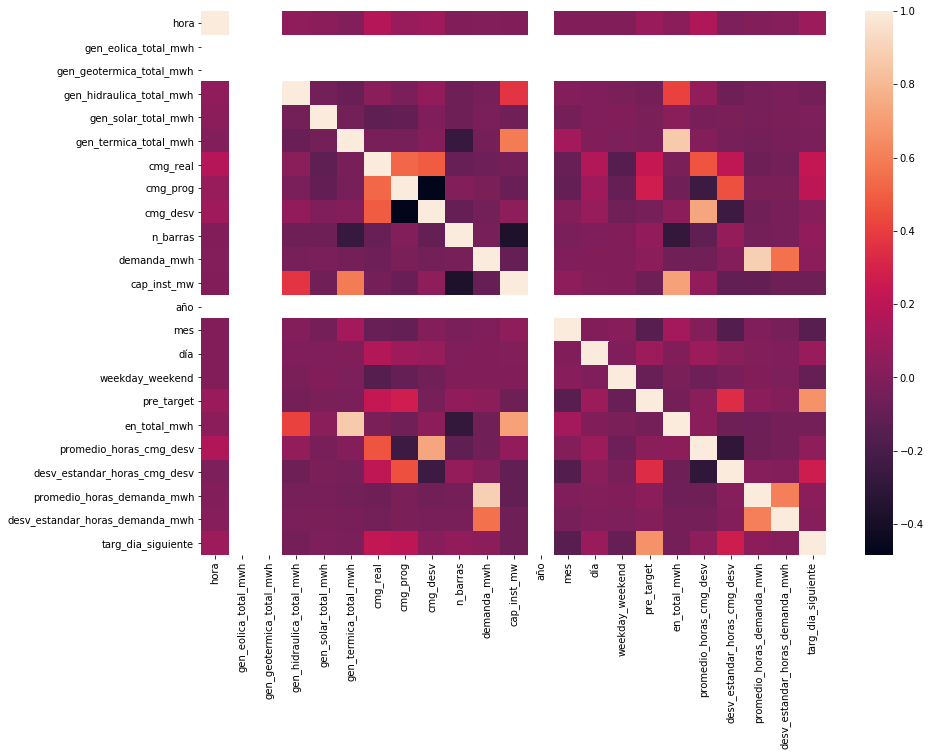

In [55]:
corr_matrix = base_para_prediccion_df_norm.corr()

plt.figure(figsize = (14,10))

sn.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

### En la figura anterior podemos ver que la variable más importante para predecir si habrá desviación al día siguiente, es saber si hubo desviación ese día (pre_target). Otras variables con importancia son desv_estandar_dias_cmg_desv, cmg_real y cmg_prog.

### Separamos nuestra columna target para entrenar el modelo. Una división común para la base de datos sería dejar un 80% y 20% de los datos para el training y test set, respectivamente. Sin embargo, este dataset contiene más de 100.000 ejemplos y nos bastarían 5.000 ejemplos aprox. para el test set. De esta manera dejamos una mayor cantidad de ejemplos para entrenar el modelo. 

In [56]:
y_values = base_para_prediccion_df_norm['targ_dia_siguiente'].values
X_values = base_para_prediccion_df_norm.drop(columns=['targ_dia_siguiente']).to_numpy()

In [57]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_values, y_values, test_size=0.045)

### Ahora entrenamos el modelo:

In [58]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

data_dir = 'Data'
prefix = 'desafio-spike' 

In [59]:
from sagemaker import LinearLearner

output_path = 's3://{}/{}'.format(bucket, prefix)

linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=100,
                       binary_classifier_model_selection_criteria='f_beta')

In [60]:
train_x = X_train.astype('float32')
train_y = Y_train.astype('float32')

train_data = linear.record_set(train_x, labels=train_y)

In [61]:
%%time 

linear.fit(train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-29 20:35:59 Starting - Starting the training job...
2020-09-29 20:36:01 Starting - Launching requested ML instances......
2020-09-29 20:37:06 Starting - Preparing the instances for training.........
2020-09-29 20:38:41 Downloading - Downloading input data...
2020-09-29 20:39:28 Training - Downloading the training image...
2020-09-29 20:39:49 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/29/2020 20:39:53 INFO 140192959059776] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5

In [62]:
%%time 

linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 322 ms, sys: 10.2 ms, total: 332 ms
Wall time: 8min 32s


### Performance en el Test Set:

In [63]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_test.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])


In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_test, result)
print(confusion_matrix)

print(classification_report(Y_test, result))

[[3530  310]
 [ 303  932]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      3840
         1.0       0.75      0.75      0.75      1235

    accuracy                           0.88      5075
   macro avg       0.84      0.84      0.84      5075
weighted avg       0.88      0.88      0.88      5075



### Performance en el Train Set:

In [65]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_train.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])


In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_train, result)
print(confusion_matrix)

print(classification_report(Y_train, result))

[[73611  6834]
 [ 6756 20499]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     80445
         1.0       0.75      0.75      0.75     27255

    accuracy                           0.87    107700
   macro avg       0.83      0.83      0.83    107700
weighted avg       0.87      0.87      0.87    107700



### Nos basaremos en el f1 score, ya que podríamos considerar nuestro target como "Skewed Data". Podemos observar que el modelo presenta más problemas para predecir casos de desviaciones mayores a 15%, teniendo un f1 score promedio de 84% (y promedio weighted de 88%). Podríamos mejorar el modelo estudiando más profundamente las variables, probando distintos modelos y realizando hyperparameter tuning.

# 6. Predicción de desviaciones del costo marginal: modelo 2

### Si ahora recibimos datos actualizados del sistema cada 12 horas, debemos adecuar nuestro target. Una opción sería predecir si el desvío promedio por hora para las próximas 12 horas estará en el rango [-15, 15]. Para esto hacemos una variable similar a la que hicimos con "promedio_horas_cmg_desv", pero esta vez nuestra ventana será de 12 horas.

In [67]:
base_para_prediccion_df['suma_12horas_cmg_real'] = base_para_prediccion_df['cmg_real'].rolling(12).sum()/12
base_para_prediccion_df['suma_12horas_cmg_prog'] = base_para_prediccion_df['cmg_prog'].rolling(12).sum()/12

In [68]:
base_para_prediccion_df['desviación_pct'] = (base_para_prediccion_df['suma_12horas_cmg_real'] 
                                    - base_para_prediccion_df['suma_12horas_cmg_prog'])*100/base_para_prediccion_df['suma_12horas_cmg_real']

In [69]:
base_para_prediccion_df['pre_target2'] = 0
base_para_prediccion_df.loc[(abs(base_para_prediccion_df['cmg_desv_pct']) > 15), 'pre_target2'] = 1

In [70]:
# Eliminamos los primeros datos, sin promedio de las últimas 12 horas:
base_para_prediccion_df = base_para_prediccion_df.dropna()
base_para_prediccion_df = base_para_prediccion_df.reset_index(drop=True)

### Tal como adecuamos la variable target en el modelo 1 para predecir si existirá una desviación en la hora siguiente, ahora debemos adecuar nuestro target para predecir si la desviación promedio por hora de las siguientes 12 horas será mayor a 15%.

In [71]:
base_para_prediccion_df['target_modelo2_12horas'] = base_para_prediccion_df['pre_target2']
for i in range(base_para_prediccion_df.shape[0]-12):
    base_para_prediccion_df['target_modelo2_12horas'][i] = base_para_prediccion_df['target_modelo2_12horas'][i+12]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [72]:
base_para_prediccion_df['target_modelo2_12horas'].value_counts()

0    84280
1    28484
Name: target_modelo2_12horas, dtype: int64

### Preparamos la base de datos para modelarla:

In [73]:
list(base_para_prediccion_df.columns.values)

['nemotecnico_se',
 'fecha',
 'hora',
 'gen_eolica_total_mwh',
 'gen_geotermica_total_mwh',
 'gen_hidraulica_total_mwh',
 'gen_solar_total_mwh',
 'gen_termica_total_mwh',
 'cmg_real',
 'cmg_prog',
 'cmg_desv',
 'cmg_desv_pct',
 'n_barras',
 'demanda_mwh',
 'cap_inst_mw',
 'año',
 'mes',
 'día',
 'día_semana',
 'weekday_weekend',
 'pre_target',
 'en_total_mwh',
 'promedio_horas_cmg_desv',
 'desv_estandar_horas_cmg_desv',
 'promedio_horas_demanda_mwh',
 'desv_estandar_horas_demanda_mwh',
 'targ_dia_siguiente',
 'suma_12horas_cmg_real',
 'suma_12horas_cmg_prog',
 'desviación_pct',
 'pre_target2',
 'target_modelo2_12horas']

In [74]:
base_para_prediccion_train = base_para_prediccion_df.drop(columns=['nemotecnico_se'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['día_semana'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['fecha'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['cmg_desv_pct'])
base_para_prediccion_train = base_para_prediccion_train.drop(columns=['targ_dia_siguiente'])

base_para_prediccion_train.shape

(112764, 27)

### Normalizamos los datos:

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

base_para_prediccion_df_norm = pd.DataFrame(scaler.fit_transform(base_para_prediccion_train.astype(float)))

base_para_prediccion_df_norm.columns = base_para_prediccion_train.columns
base_para_prediccion_df_norm.index = base_para_prediccion_train.index

### Ahora que está listo nuestro target, entrenamos el modelo 2:

In [76]:
y_values = base_para_prediccion_df_norm['target_modelo2_12horas'].values
X_values = base_para_prediccion_df_norm.drop(columns=['target_modelo2_12horas']).to_numpy()

In [77]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_values, y_values, test_size=0.045)

In [78]:
from sagemaker import LinearLearner

output_path = 's3://{}/{}'.format(bucket, prefix)

linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=100,
                       binary_classifier_model_selection_criteria='f_beta')

In [79]:
train_x = X_train.astype('float32')
train_y = Y_train.astype('float32')

train_data = linear.record_set(train_x, labels=train_y)

In [80]:
%%time 

linear.fit(train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-29 20:54:05 Starting - Starting the training job...
2020-09-29 20:54:09 Starting - Launching requested ML instances......
2020-09-29 20:55:14 Starting - Preparing the instances for training......
2020-09-29 20:56:35 Downloading - Downloading input data...
2020-09-29 20:57:01 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/29/2020 20:57:05 INFO 140334132242240] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_

In [81]:
%%time 

linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------------------!CPU times: user 523 ms, sys: 13.3 ms, total: 536 ms
Wall time: 15min 33s


### Performance del Test Set

In [82]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_test.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_test, result)
print(confusion_matrix)

print(classification_report(Y_test, result))

[[1995 1839]
 [ 312  929]]
              precision    recall  f1-score   support

         0.0       0.86      0.52      0.65      3834
         1.0       0.34      0.75      0.46      1241

    accuracy                           0.58      5075
   macro avg       0.60      0.63      0.56      5075
weighted avg       0.74      0.58      0.60      5075



### Performance del Train Set

In [84]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_train.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_train, result)
print(confusion_matrix)

print(classification_report(Y_train, result))

[[41221 39225]
 [ 6939 20304]]
              precision    recall  f1-score   support

         0.0       0.86      0.51      0.64     80446
         1.0       0.34      0.75      0.47     27243

    accuracy                           0.57    107689
   macro avg       0.60      0.63      0.55    107689
weighted avg       0.73      0.57      0.60    107689



### Vemos que el modelo 2 tiene peor performance que el modelo 1, con un f1 score promedio de 56% (y promedio weighted de 60%). Esto podría deberse a que 12 horas es un rango muy grande para hacer predicciones y deberíamos estudiar con mayor profundidad el problema para mejorar el performance del modelo. 

# 7. Merge con datos de clima: modelo 3

### Importamos los datos del clima:

In [86]:
clima_df = 'Data/datos_clima.csv'
clima_df = pd.read_csv(clima_df)

clima_df.head()

,fecha,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06 00:00:00 UTC,SE019T002,-28.470641,-71.252694,2.0,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.0,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08 00:00:00 UTC,SE004T002,-39.549899,-72.912208,2.0,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07 00:00:00 UTC,SE003T011,-35.685919,-71.377335,2.0,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96


In [87]:
clima_df.rename(columns={'subestacion': 'nemotecnico_se'}, inplace=True)

In [88]:
clima_df['fecha'] = clima_df['fecha'].astype('datetime64[ns]')

### Hacemos el merge de las bases de datos y la ordenamos:

In [89]:
modelo_3_df = pd.merge(base_para_prediccion_df, clima_df, 
                          how='inner',  
                          left_on=['nemotecnico_se','fecha'], 
                          right_on = ['nemotecnico_se','fecha'])

In [90]:
modelo_3_df = modelo_3_df.sort_values(['nemotecnico_se', 'fecha', 'hora'])
modelo_3_df = modelo_3_df.reset_index(drop=True)
modelo_3_df.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE001T002,2019-01-01,16,0.0,0.0,0.0,0.20,0.0,0.00,42.584535,...,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
1,SE001T002,2019-01-01,17,0.0,0.0,0.0,0.19,0.0,0.00,42.584535,...,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
2,SE001T002,2019-01-01,18,0.0,0.0,0.0,0.17,0.0,22.09,42.584535,...,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
3,SE001T002,2019-01-01,19,0.0,0.0,0.0,0.11,0.0,50.09,45.032415,...,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
4,SE001T002,2019-01-01,20,0.0,0.0,0.0,0.00,0.0,50.09,48.890750,...,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21


### Eliminamos columnas innecesarias:

In [91]:
list(modelo_3_df.columns.values)

['nemotecnico_se',
 'fecha',
 'hora',
 'gen_eolica_total_mwh',
 'gen_geotermica_total_mwh',
 'gen_hidraulica_total_mwh',
 'gen_solar_total_mwh',
 'gen_termica_total_mwh',
 'cmg_real',
 'cmg_prog',
 'cmg_desv',
 'cmg_desv_pct',
 'n_barras',
 'demanda_mwh',
 'cap_inst_mw',
 'año',
 'mes',
 'día',
 'día_semana',
 'weekday_weekend',
 'pre_target',
 'en_total_mwh',
 'promedio_horas_cmg_desv',
 'desv_estandar_horas_cmg_desv',
 'promedio_horas_demanda_mwh',
 'desv_estandar_horas_demanda_mwh',
 'targ_dia_siguiente',
 'suma_12horas_cmg_real',
 'suma_12horas_cmg_prog',
 'desviación_pct',
 'pre_target2',
 'target_modelo2_12horas',
 'lat',
 'lon',
 'ALLSKY_SFC_SW_DWN',
 'KT',
 'PRECTOT',
 'RH2M',
 'T2M',
 'T2MDEW',
 'T2M_MAX',
 'T2M_MIN',
 'TQV',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN']

In [92]:
modelo_3_df_train = modelo_3_df.drop(columns=['nemotecnico_se'])
modelo_3_df_train = modelo_3_df_train.drop(columns=['día_semana'])
modelo_3_df_train = modelo_3_df_train.drop(columns=['fecha'])
modelo_3_df_train = modelo_3_df_train.drop(columns=['cmg_desv_pct'])
modelo_3_df_train = modelo_3_df_train.drop(columns=['targ_dia_siguiente'])

### Normalizamos:

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

modelo_3_df_norm = pd.DataFrame(scaler.fit_transform(modelo_3_df_train.astype(float)))

modelo_3_df_norm.columns = modelo_3_df_train.columns
modelo_3_df_norm.index = modelo_3_df_train.index

### Buscamos las variables más importantes:

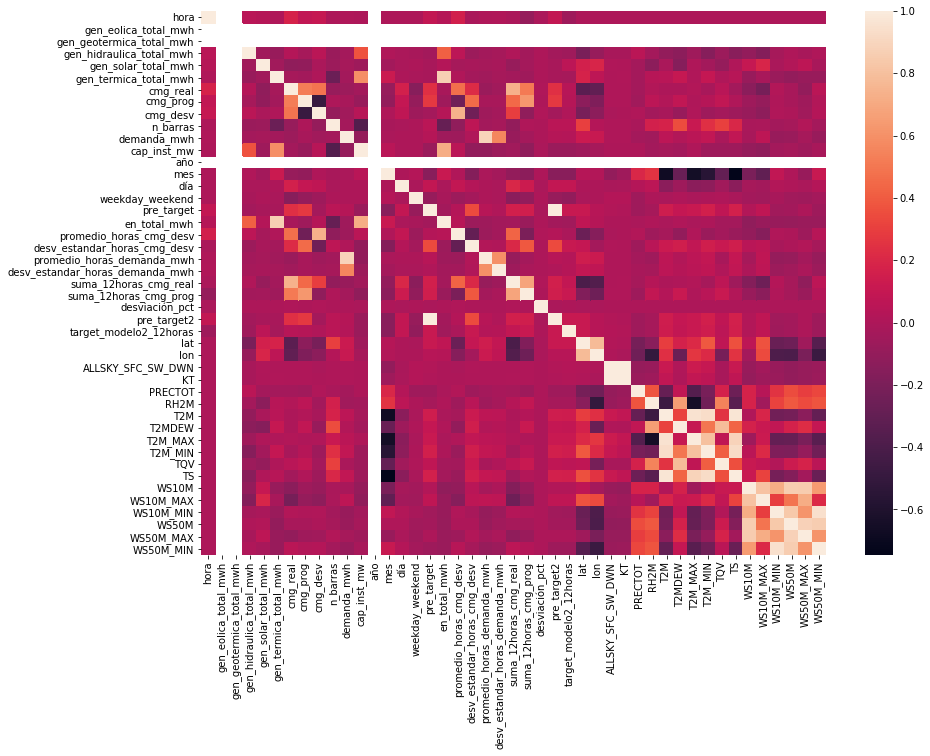

In [94]:
corr_matrix = modelo_3_df_norm.corr()

plt.figure(figsize = (14,10))

sn.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

### Vemos que las variables más importantes para predecir nuestro target están en la zona de los datos del clima. Esto indicaría que agregar estos datos debería mejorar el performance del modelo.

### Entrenamos el modelo:

In [96]:
y_values = modelo_3_df_norm['target_modelo2_12horas'].values
X_values = modelo_3_df_norm.drop(columns=['target_modelo2_12horas']).to_numpy()

In [97]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_values, y_values, test_size=0.045)

In [98]:
from sagemaker import LinearLearner

output_path = 's3://{}/{}'.format(bucket, prefix)

linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=100,
                       binary_classifier_model_selection_criteria='f_beta')

In [99]:
train_x = X_train.astype('float32')
train_y = Y_train.astype('float32')

train_data = linear.record_set(train_x, labels=train_y)

In [100]:
%%time 

linear.fit(train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-29 21:19:48 Starting - Starting the training job...
2020-09-29 21:19:50 Starting - Launching requested ML instances......
2020-09-29 21:20:58 Starting - Preparing the instances for training...
2020-09-29 21:21:48 Downloading - Downloading input data......
2020-09-29 21:22:39 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/29/2020 21:22:42 INFO 140422445799232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_m

In [101]:
%%time 

linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 320 ms, sys: 5.24 ms, total: 326 ms
Wall time: 8min 33s


### Performance Test Set

In [102]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_test.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])

In [103]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_test, result)
print(confusion_matrix)

print(classification_report(Y_test, result))

[[2287 1507]
 [ 415  866]]
              precision    recall  f1-score   support

         0.0       0.85      0.60      0.70      3794
         1.0       0.36      0.68      0.47      1281

    accuracy                           0.62      5075
   macro avg       0.61      0.64      0.59      5075
weighted avg       0.72      0.62      0.65      5075



### Performance Train Set

In [104]:
batches = [linear_predictor.predict(batch) for batch in np.array_split(X_train.astype('float32'), 10)]

result = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) for batch in batches])

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(Y_train, result)
print(confusion_matrix)

print(classification_report(Y_train, result))

[[48291 32195]
 [ 8131 19072]]
              precision    recall  f1-score   support

         0.0       0.86      0.60      0.71     80486
         1.0       0.37      0.70      0.49     27203

    accuracy                           0.63    107689
   macro avg       0.61      0.65      0.60    107689
weighted avg       0.73      0.63      0.65    107689



### Vemos que el performance del modelo efectivamente mejora con respecto a la pregunta anterior. Ahora tenemos un f1 score promedio de 59% (y promedio weighted de 65%). Esto indicaría que la capacidad predictiva mejoró un 5.4% y 8.3% para el f1 score promedio y promedio weighted, respectivamente.

# 8. Reflexión

### Como el Sistema Eléctrico Nacional usa primero las fuentes de energía de bajo costo variable (pero alto costo fijo) y luego las de alto costo variable (pero bajo costo fijo) para las horas peak, el saber si habrá un desvío del costo marginal permitiría ser más eficientes con los recursos y lograr que las proyecciones sean lo más cercanas a la realidad.


### Casos que podrían beneficiarse con modelos como este son proyectos donde la energía impacta mucho al resultado; donde sobreestimar o subestimar los costos de energía podría traducirse en desechar proyectos rentables o usar parte de las utilidades previstas, respectivamente.